In [1]:
import mxnet as mx
import time
import random
import os
import numpy as np
np.set_printoptions(precision=2)
import argparse

from skimage import io, transform, exposure, color

In [2]:
def descriptor_resnet_symbol(num_res):
    data = mx.sym.Variable('data')
    num_filter = 64
    conv0 = mx.sym.Convolution(name='conv0', data=data, weight=mx.sym.Variable('conv0_weight'), num_filter=num_filter, pad=(3,3), kernel=(7,7), stride=(2,2), no_bias=True, workspace=1024)
    bn0 = mx.sym.BatchNorm(data=conv0, momentum=0.9, name='batchnorm0', gamma=mx.sym.Variable('batchnorm0_gamma'), beta=mx.sym.Variable('batchnorm0_beta'), moving_mean=mx.sym.Variable('batchnorm0_running_mean'), moving_var=mx.sym.Variable('batchnorm0_running_var'))
    relu0 = mx.symbol.Activation(name='relu0', data=bn0 , act_type='relu')
    pool0 = mx.sym.Pooling(data=relu0, kernel=(3,3), stride=(2,2), pad=(1,1), pool_type='max')
    weight_var = {}
    gamma_var = {}
    beta_var = {}
    index = 0 
    convs = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4']
    bns = ['batchnorm0', 'batchnorm1', 'batchnorm2', 'batchnorm3', 'batchnorm4']
    s = ['stage1_', 'stage2_', 'stage3_', 'stage4_']
    for i in range(num_res):
        num_filter = 64 * (2**i)
        print(s[i], num_filter)
        weight_var = {}
        gamma_var = {}
        beta_var = {}
        running_mean_var = {}
        running_var_var = {}
        for k in convs:
            weight_var[s[i]+k] = mx.sym.Variable(s[i]+k+'_weight')
        for b in bns:
            gamma_var[s[i]+b] =  mx.sym.Variable(s[i]+b+'_gamma')
            beta_var[s[i]+b] =  mx.sym.Variable(s[i]+b+'_beta')
            running_mean_var[s[i]+b] = mx.sym.Variable(s[i]+b+'_running_mean')
            running_var_var[s[i]+b] =mx.sym.Variable(s[i]+b+'_running_var')
        if i == 0:
            out = resnet_symbol(pool0, weight_var, gamma_var, beta_var, running_mean_var, running_var_var, 0, s[i], num_filter)
        else:
            out = resnet_symbol(out, weight_var, gamma_var, beta_var, running_mean_var, running_var_var, 1, s[i], num_filter)
    return out

def resnet_symbol(data, weight, gamma, beta, running_mean, running_var, index, stage, num_filter):
    def conv(name, data, num_filter, pad, kernel, stride, workspace):
        return mx.sym.Convolution(name=name, data=data, weight=weight[name], num_filter=num_filter, pad=pad, kernel=kernel, stride=stride, no_bias=True, workspace=workspace)
    def bn(name, data, momentum):
        return mx.sym.BatchNorm(data=data, momentum=momentum, name=name, gamma=gamma[name], beta=beta[name], moving_mean=running_mean[name], moving_var=running_var[name])
    if index == 0:
        conv0 = conv(name=stage+'conv0', data=data , num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn0 = bn(data=conv0, momentum=0.9, name=stage+'batchnorm0')
        relu0 = mx.symbol.Activation(name=stage+'relu0', data=bn0, act_type='relu')
        conv1 = conv(name=stage+'conv1', data=relu0, num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn1 = bn(data=conv1, momentum=0.9, name=stage+'batchnorm1')
        relu1 = mx.symbol.Activation(name=stage+'relu1', data=bn1 + data, act_type='relu')
        conv2 = conv(name=stage+'conv2', data=relu1, num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn2 = bn(data=conv2, momentum=0.9, name=stage+'batchnorm2')
        relu2 = mx.symbol.Activation(name=stage+'relu2', data=bn2, act_type='relu')
        conv3 = conv(name=stage+'conv3', data=relu2, num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn3 = bn(data=conv3, momentum=0.9, name=stage+'batchnorm3')
        relu3 = mx.symbol.Activation(name=stage+'relu3', data=bn3, act_type='relu')
        return relu3
    elif index == 1:
        conv0 = conv(name=stage+'conv0', data=data , num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(2,2), workspace=1024)
        bn0 = bn(data=conv0, momentum=0.9, name=stage+'batchnorm0')
        relu0 = mx.symbol.Activation(name=stage+'relu0', data=bn0, act_type='relu')
        conv1 = conv(name=stage+'conv1', data=relu0, num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn1 = bn(data=conv1, momentum=0.9, name=stage+'batchnorm1')
        conv2 = conv(name=stage+'conv2', data=data, num_filter=num_filter, pad=(1,1), kernel=(1,1), stride=(2,2), workspace=1024)
        bn2 = bn(data=conv2, momentum=0.9, name=stage+'batchnorm2')
        relu1 = mx.symbol.Activation(name=stage+'relu1', data=bn1+bn2, act_type='relu')
        conv3 = conv(name=stage+'conv3', data=relu1, num_filter=num_filter, pad=(0,0), kernel=(3,3), stride=(1,1), workspace=1024)
        bn3 = bn(data=conv3, momentum=0.9, name=stage+'batchnorm3')
        relu3 = mx.symbol.Activation(name=stage+'relu3', data=bn3, act_type='relu')
        conv4 = conv(name=stage+'conv4', data=relu3, num_filter=num_filter, pad=(1,1), kernel=(3,3), stride=(1,1), workspace=1024)
        bn4 = bn(data=conv4, momentum=0.9, name=stage+'batchnorm4')
        relu4 = mx.symbol.Activation(name=stage+'relu4', data=bn4, act_type='relu')
        return relu4
    

stage1_ 64
stage2_ 128
stage3_ 256
stage4_ 512


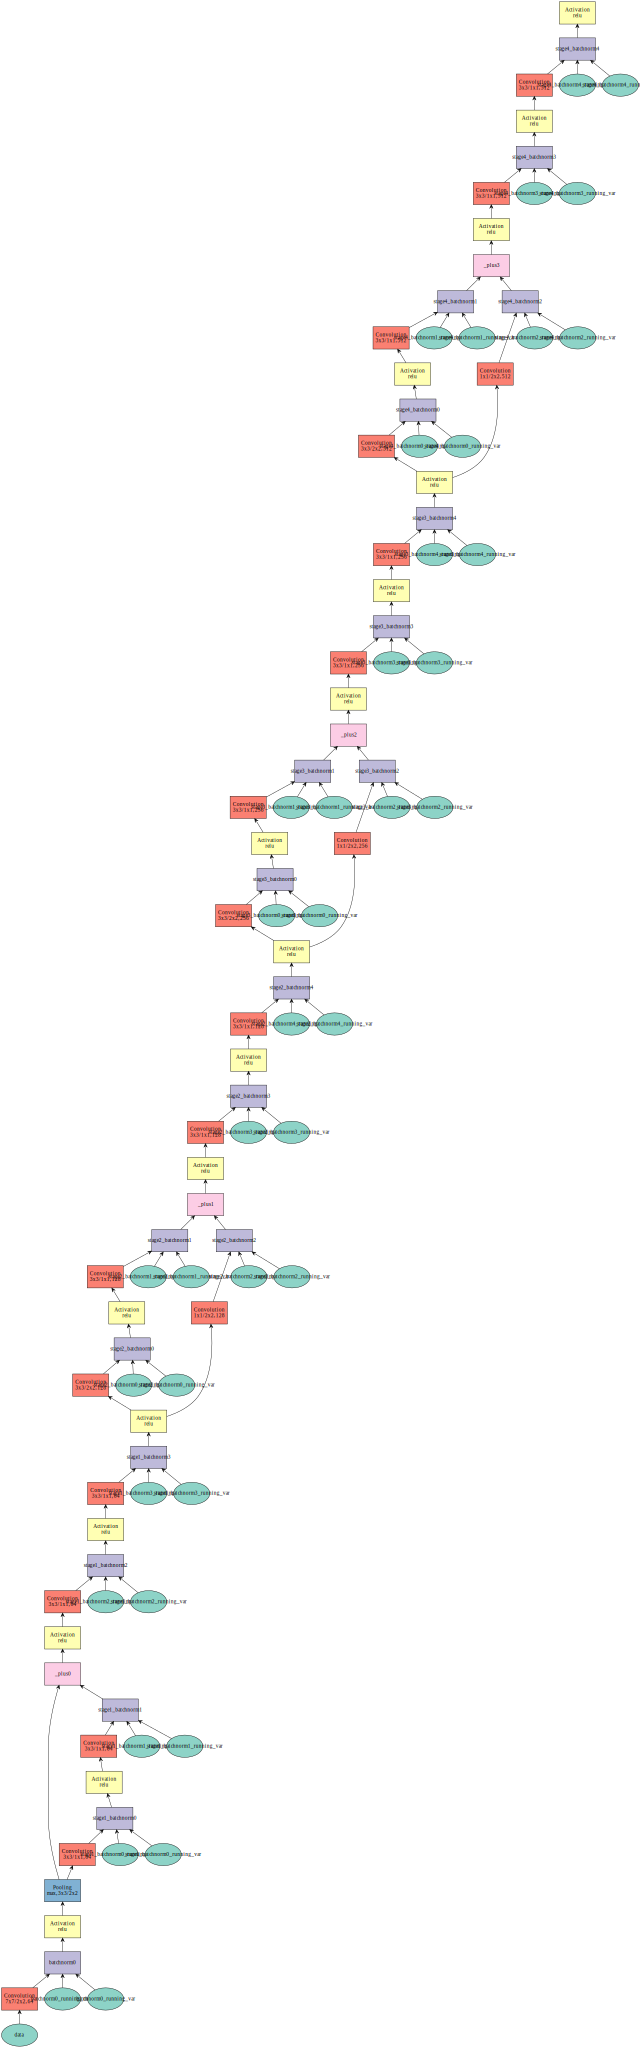

In [3]:
resnet_symbol = descriptor_resnet_symbol(4)
mx.viz.plot_network(resnet_symbol)



In [4]:
arg_names =resnet_symbol.list_arguments()
arg_dict = {}
pretrained = mx.nd.load('../resnet18.params')
for name in arg_names:
    if name == "data":
        continue
    key = name
    if key in pretrained:
        arg_dict[name] = pretrained[key].copyto(mx.gpu())
print(arg_dict.keys())

dict_keys(['stage2_batchnorm0_beta', 'stage4_batchnorm3_beta', 'stage4_conv0_weight', 'stage3_batchnorm1_beta', 'stage3_conv2_weight', 'stage2_conv3_weight', 'batchnorm0_gamma', 'stage4_conv2_weight', 'stage4_conv4_weight', 'stage2_batchnorm4_gamma', 'stage4_conv3_weight', 'stage4_batchnorm2_beta', 'stage3_conv4_weight', 'stage1_conv2_weight', 'stage1_batchnorm2_beta', 'conv0_weight', 'stage3_batchnorm1_gamma', 'stage3_conv3_weight', 'stage1_conv3_weight', 'stage3_batchnorm2_beta', 'stage1_batchnorm3_beta', 'stage1_batchnorm0_gamma', 'stage2_batchnorm2_beta', 'stage1_batchnorm0_beta', 'stage2_batchnorm0_gamma', 'stage2_batchnorm2_gamma', 'stage2_batchnorm1_beta', 'stage2_conv4_weight', 'stage4_batchnorm0_beta', 'stage2_conv2_weight', 'stage2_batchnorm3_gamma', 'stage1_conv1_weight', 'stage1_batchnorm1_gamma', 'stage2_batchnorm3_beta', 'stage4_batchnorm0_gamma', 'stage3_conv1_weight', 'stage2_batchnorm1_gamma', 'stage3_conv0_weight', 'stage3_batchnorm0_gamma', 'stage1_conv0_weight', 'st

In [16]:
aux_names = resnet_symbol.list_auxiliary_states()
aux_dict = {}
for name in aux_names:
    if name == "data":
        continue
    key = name
    if key in pretrained:
        aux_dict[name] = pretrained[key].copyto(mx.gpu())
#print(aux_dict.keys())

for i in resnet_symbol.list_inputs():
    print(i)

data
conv0_weight
batchnorm0_gamma
batchnorm0_beta
batchnorm0_running_mean
batchnorm0_running_var
stage1_conv0_weight
stage1_batchnorm0_gamma
stage1_batchnorm0_beta
stage1_batchnorm0_running_mean
stage1_batchnorm0_running_var
stage1_conv1_weight
stage1_batchnorm1_gamma
stage1_batchnorm1_beta
stage1_batchnorm1_running_mean
stage1_batchnorm1_running_var
stage1_conv2_weight
stage1_batchnorm2_gamma
stage1_batchnorm2_beta
stage1_batchnorm2_running_mean
stage1_batchnorm2_running_var
stage1_conv3_weight
stage1_batchnorm3_gamma
stage1_batchnorm3_beta
stage1_batchnorm3_running_mean
stage1_batchnorm3_running_var
stage2_conv0_weight
stage2_batchnorm0_gamma
stage2_batchnorm0_beta
stage2_batchnorm0_running_mean
stage2_batchnorm0_running_var
stage2_conv1_weight
stage2_batchnorm1_gamma
stage2_batchnorm1_beta
stage2_batchnorm1_running_mean
stage2_batchnorm1_running_var
stage2_conv2_weight
stage2_batchnorm2_gamma
stage2_batchnorm2_beta
stage2_batchnorm2_running_mean
stage2_batchnorm2_running_var
stage2

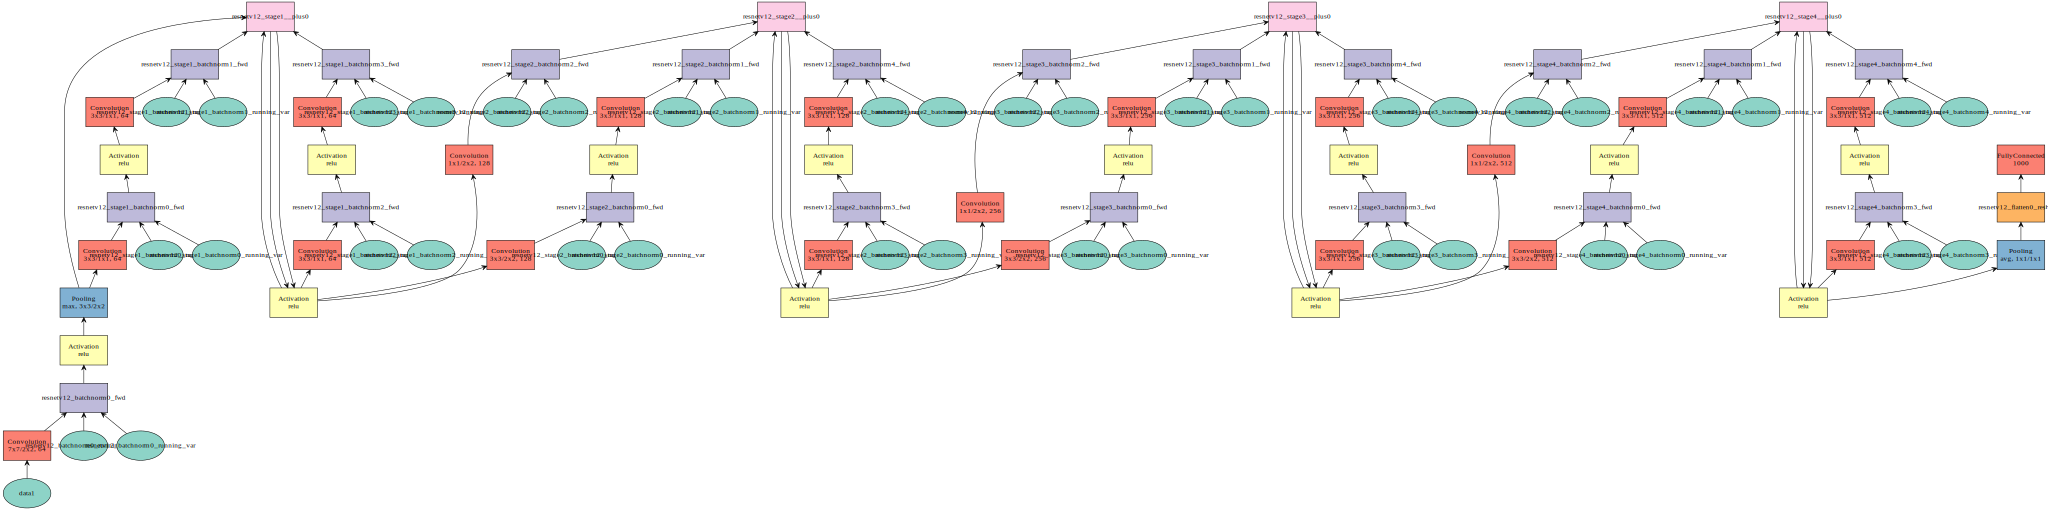

In [8]:
from mxnet.gluon.model_zoo.vision import resnet18_v1
resnet = resnet18_v1(pretrained=True)
data1 = mx.sym.Variable("data1")
resnet_symbol111 = resnet(data1)
mx.viz.plot_network(resnet_symbol111)


In [9]:
print(resnet)

ResNetV1(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
          (2): Activation(relu)
          (3): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05, axis=1)
        )
      )
      (1): BasicBlockV1(
        (body): HybridSequential(
          (0): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm(fix_gamma=False, momentum=0.9, eps=1e-05

In [ ]:
weight_var = {}
bias_var = {}
convs = ['conv0', 'conv1', 'conv2', 'conv3', 'conv4']
for k in convs:
    weight_var[k] = mx.sym.Variable(k+'_weight')
weight_var = {}
bias_var = {}

In [27]:
resnet = resnet18_v1(pretrained=True)
data1 = mx.sym.Variable("data1")
resnet.infer_shape()

TypeError: hybrid_forward() missing 1 required positional argument: 'x'